# Women And Children First

## Introduction

The goal of this short project is to **assess whether survival rates on the _Titanic_ obeyed the non-written rule "women and children first."** To do that, I put together a more comprehensive dataset than you'd normally find on most ML websites and such likes; see the [data wrangling](https://github.com/NicolaBagala/portfolio/blob/master/data/titanic/titanic_wrangling.ipynb) part of this project for more information on the data sources. This analysis is also available [code-free](https://github.com/NicolaBagala/portfolio/blob/master/data/titanic/codefree/titanic_analysis_codefree.ipynb), if you prefer.

The fact that victims of the _Titanic_ were mostly men, both in absolute and percentage terms, is actually nothing new, but I was curious to see whether this fact was true also when accounting for factors like age, affiliation (i.e., passenger or crew member), class, etc. That's what we'll do in this project.

## Setting up

For plotting charts, I am going to use Matplotlib and a bit of Seaborn. As a side note, while I was browsing its documentation, I noticed Seaborn comes with an embedded _Titanic_ dataset. The irony of that didn't escape me, but it's okay—the dataset I built is larger.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

# Set seaborn's default theme, which I like quite enough.
sns.set_theme()
sns.set_context("notebook", font_scale = 1.5)

# Read in the dataset.
titanic = pd.read_csv("titanic.csv", header = 0)

In [4]:
# Colour schemes used in charts. (See below about the meaning of "SHF".)
sex_color = {"Male": "cornflowerblue",
             "Female": "mediumorchid",                          
             "Any": "grey"}

class_color = {"First": "gold", 
               "Second": "silver",
               "Third": "peru"}

survival_color = {False: "red",
                  True: "limegreen"}

affiliation_color = {"Crew": "deepskyblue",
                     "Passengers": "darkmagenta",                    
                     "Any": "grey"}

## The dataset

The dataset contains information about 2165 people in total, which is just barely short of the estimated full number of people onboard ([2,224](https://en.wikipedia.org/wiki/Titanic) according to Wikipedia.) Of these, 1304 were passengers and 861 were crew.

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   NAME         2165 non-null   object 
 1   AGE          1903 non-null   float64
 2   SEX          2165 non-null   object 
 3   AFFILIATION  2165 non-null   object 
 4   GROUP        2165 non-null   object 
 5   POSITION     2165 non-null   object 
 6   CLASS        2165 non-null   object 
 7   SURVIVED     2165 non-null   bool   
dtypes: bool(1), float64(1), object(6)
memory usage: 120.6+ KB


Let's briefly look into each of the columns.
- `NAME`, `AGE`, and `SEX` are just standard demographic information.
- `AFFILIATION` is either `Crew` or `Passengers`, and it is used exclusively to be able to quickly separate the two sets of people.
- `GROUP` applies to crew members only, and it identifies the eight broader groups to which a crew member could belong: Officers, Deck, Engineering, Victualling, Restaurant, Postal clerks, Guarantee group, and Orchestra. For passengers, this column has value `Not applicable`.
- `POSITION` identifies the specific job of each crew member. For passengers, this column has value `Not applicable`.
- `CLASS` can be `First`, `Second`, or `Third` in the case of passengers and of the Guarantee group crew members, who for some reason were given passenger accommodations. For other crew members, this column has value `Not applicable`.
- `SURVIVED` is a boolean: `True` for people who survived the disaster, `False` for those who didn't make it.

In some instances, we're going to compare actual survival and death rates with partly randomised ones, obtained by randomly choosing 1462 people as victims and the rest as survivors. (As we'll see later on, 1462 is the number of actual victims in the dataset.) The overall randomised death and survival rates will be identical to the originals, but all other possible influencing factors will be eliminated. In other words, we'll know there are 1462 victims whose age, sex, affiliation, etc played no role in their fate. For the rest of the analysis, we'll refer to the ensemble of randomly chosen survivors and victims as the *shuffled Titanic*; the *shuffled crew*, the *shuffled passengers*, etc, will refer to randomly chosen survivors/victims among the crew, the passengers, etc. We'll often use the abbreviation "SHF" to refer to shuffled groups of people.

In [6]:
# Make a new column for randomly determined survival. Everyone survives at first.
titanic["SHF_SURVIVED"] = True

# Shuffle the dataset. (random_state = 1 for reproducibility.)
titanic = titanic.sample(frac = 1, random_state = 1)

# Mark the first 1462 people of the shuffled dataset as dead. (-1 is the position of the last column, SHF_SURVIVED)
titanic.iloc[0:1463, -1] = False

# Reorder the dataset the way it was at the beginning.
titanic.sort_index(inplace = True)

As we're also going to need to compare different age brackets, let's assign each passenger and crew member to their respective bracket.

In [7]:
def assign_age_bracket(age):
    """Determine the age bracket of a person. Brackets start at 0 and have length 10. (e.g., 0-9, 10-19, etc.)    
    `age`: person's age in years (numeric type).
    
    Returns: a string representing the age bracket. If `age` is null, return "Unkn." (short for "Unknown")
    """
    from math import isnan
    
    if isnan(age): return "Unkn."
    
    tens_figure = age // 10
    left_boundary = int(tens_figure * 10)
    right_boundary = int(left_boundary + 9)
    return "{}-{}".format(left_boundary, right_boundary)

# Assign each person to their respective age bracket.
titanic["AGE_BRACKET"] = titanic["AGE"].map(assign_age_bracket)

## Broad overview

Before analysing death and survival rates of crew and passengers, let's familiarise a bit with both on a broader level.

On average, both crew members and passengers of the _Titanic_ were fairly young; the mean age on board was just above 30, and most of the people were between 20 and 40, especially among the crew. If age-wise the two groups are quite different, they're even more so sex-wise.

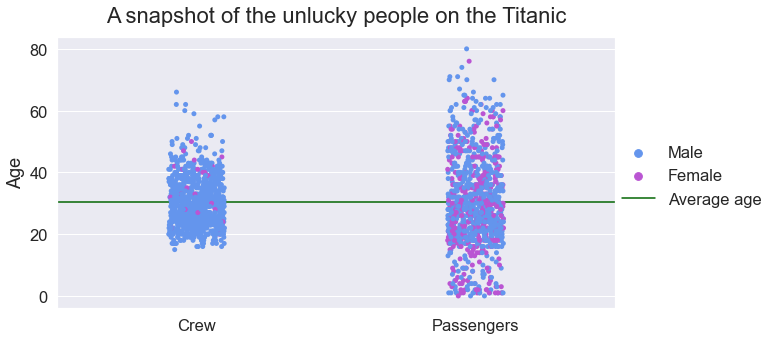

In [8]:
fig_snapshot, ax_snapshot = plt.subplots(1, 1, figsize = (10, 5))

# Plot age and sex of crew and passengers.
sns.stripplot(x = "AFFILIATION", y = "AGE", hue = "SEX",
              order = ["Crew", "Passengers"], hue_order = ["Male", "Female"], palette = sex_color,
              data = titanic,  ax = ax_snapshot)
avg_age = ax_snapshot.axhline(titanic["AGE"].mean(), color = "darkgreen", label = "Average age")

# Customise legend.
handles, labels = ax_snapshot.get_legend_handles_labels()
handles.append(avg_age)
ax_snapshot.legend(handles, labels, loc = (1, 0.35), frameon = False)

# Customise axes and title.
ax_snapshot.set_xlabel("")
ax_snapshot.set_ylabel("Age")
ax_snapshot.set_title("A snapshot of the unlucky people on the Titanic", fontsize = 22, y = 1.03);

_`Figure 1. Age and sex distribution of the Titanic's crew and passengers.`_

Overall, most people on the ship were male. Women constituted only a very small fraction of the crew, and only about 36% of the passengers.

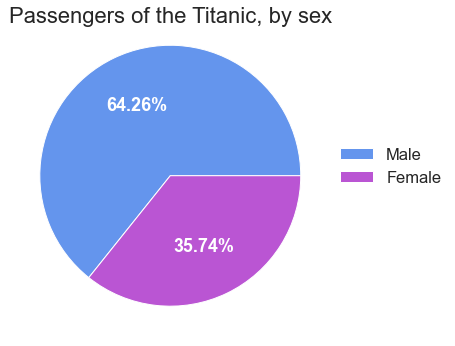

In [9]:
passengers = titanic.query("AFFILIATION == 'Passengers'")

# Sex distribution of the passengers.
passengers_by_sex = passengers["SEX"].value_counts()

fig_passengers_by_sex, ax_passengers_by_sex = plt.subplots(1, 1, figsize = (6, 6))

ax_passengers_by_sex.pie(x = passengers_by_sex, autopct = "%.2f%%", labels = ["", ""], colors = list(sex_color.values()),
                         textprops = {"color": "white", "fontweight": "bold"})

ax_passengers_by_sex.set_title("Passengers of the Titanic, by sex", fontsize = 22, y = 0.95)
ax_passengers_by_sex.legend(loc = (1, 0.45), frameon = False, labels = ["Male", "Female"]);

_`Figure 2. Sex distribution of the Titanic's passengers.`_

Below we'll build a bar chart visualising the composition of the different crew groups by sex. The victualling and engineering people constituted the vast majority of the crew; most women belonged to the victualling crew, and only very few of them were part of the restaurant crew.

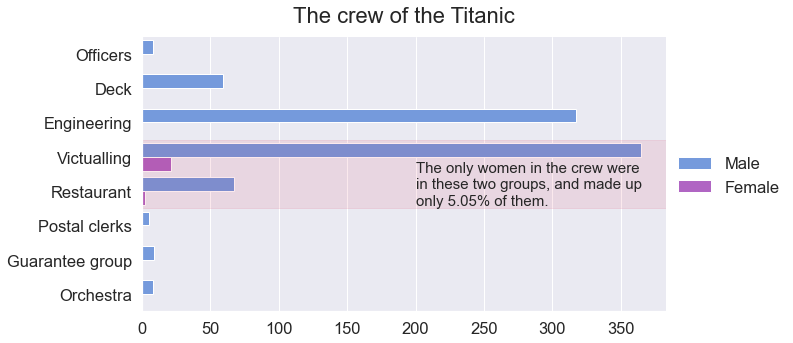

In [10]:
crew = titanic.query("AFFILIATION == 'Crew'")

# Victualling and restaurant were the only groups with female crew. Find out in what percentage.
female_pct_vict_and_rest = (crew.query("GROUP == 'Victualling' or GROUP == 'Restaurant'")
                                .value_counts(subset = "SEX", normalize = True)["Female"] * 100).round(2)

# Plot the group counts.
crew_groups_grid = sns.catplot(y = "GROUP", hue = "SEX", data = crew, orient = "h", kind = "count",
                               height = 5, aspect = 16/8, palette = sex_color, legend = False)

# Extract the axes from catplot's FacetGrid object.
ax_crew_groups = crew_groups_grid.axes[0][0]

# Customise title, axes, and legend.
ax_crew_groups.set_title("The crew of the Titanic", fontsize = 22, y = 1.03)
ax_crew_groups.set_ylabel("")
ax_crew_groups.set_xlabel("")
ax_crew_groups.legend(loc = (1.01, 0.4), frameon = False)

# Add info text and highlight relevant groups.
ax_crew_groups.text(200, 4.40,  ("The only women in the crew were\n"
                                "in these two groups, and made up\n"
                                 "only {}% of them."
                             .format(female_pct_vict_and_rest)),
                             fontsize = "small");
highlight = patches.Rectangle((0, 2.5), 390, 2, color = "crimson", alpha = 0.09)
ax_crew_groups.add_patch(highlight);

_`Figure 3. The Titanic's crew, by group and sex.`_

With the exception of the nine people in the Guarantee group, crew members had different accomodations than the passengers that weren't divided by class in the same way. For both sexes, the majority of the passengers had a third-class accommodation (which is unsurprising because of price considerations), but the percentages of men and women in third class differ significantly, about 60% and 45% respectively. Slightly more female passengers, in percentage, occupied second-class accommodations, and about 11% more females than males occupied first-class accommodations.

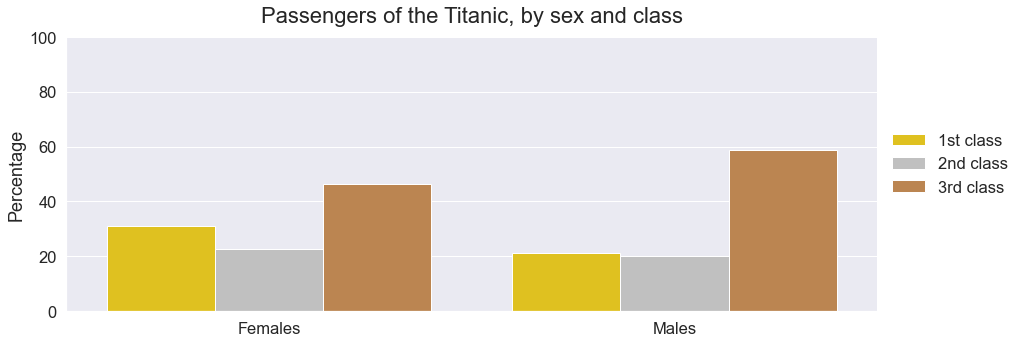

In [11]:
# Calculate percentages of passengers by sex and class.
pct_passengers_by_sex_and_class = (passengers.groupby("SEX")["CLASS"].value_counts(normalize = True)
                                                                       .mul(100).round(2)
                                                                       .rename("Percentage").reset_index()
                                                                       .sort_values("CLASS"))
# Plot the above percentages.
passengers_by_sex_and_class_grid = sns.catplot(x = "SEX", y = "Percentage", hue = "CLASS",  
                                               kind = "bar", data = pct_passengers_by_sex_and_class, 
                                               height = 5, aspect = 20/8, palette = class_color, legend = False)

# Customise title, axes, and legend.
ax_passengers_by_sex_and_class = passengers_by_sex_and_class_grid.axes[0][0]
ax_passengers_by_sex_and_class.set_title("Passengers of the Titanic, by sex and class", fontsize = 22, y = 1.03)
ax_passengers_by_sex_and_class.set_xlabel("")
ax_passengers_by_sex_and_class.set_xticklabels(["Females", "Males"])
ax_passengers_by_sex_and_class.set_ylim(0, 100)
handles, _ = ax_passengers_by_sex_and_class.get_legend_handles_labels()
ax_passengers_by_sex_and_class.legend(loc = (1.01, 0.4), handles = handles, labels = ["1st class", "2nd class", "3rd class"], frameon = False);

_`Figure 4. Passengers of the Titanic, by sex and class.`_

## Analysis of the survivors

Let's move on to survival and death rates, to see if and how they vary when accounting for different factors. Let's start with the larger picture: **Overall, 67.5% of the people aboard the ship died—that is 1462 people.**

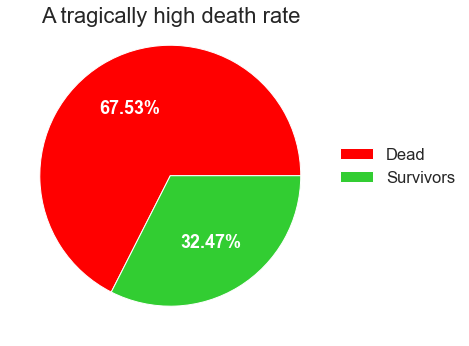

In [12]:
fig_survival_and_death, ax_survival_and_death = plt.subplots(1, 1, figsize = (6, 6))

# Plot survival and death rates.
ax_survival_and_death.pie(x = titanic["SURVIVED"].value_counts(), autopct = "%.2f%%", labels = ["", ""], colors = list(survival_color.values()),
                          textprops = {"color": "white", "fontweight": "bold"})

ax_survival_and_death.legend(loc = (1, 0.45), frameon = False, labels = ["Dead", "Survivors"])
ax_survival_and_death.set_title("A tragically high death rate", fontsize = 22, y = 0.95);

_`Figure 5. Survival and death rates on the whole ship.`_

**Amongst the dead, around 91% were men, while only about 9% were women.** The split among survivors is instead nearly 50-50 between males and females. Put another way, if you picked a _Titanic_ survivor at random, they could be almost equally likely a man or a woman; if you picked a random victim, the odds are the person was male.

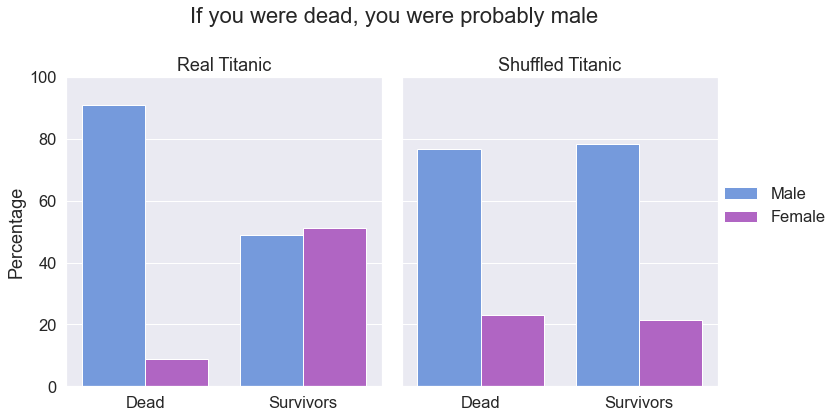

In [13]:
# Calculate percent of each sex among dead and survivors, both actual and shuffled.
pct_of_sex_by_survival = titanic.groupby("SURVIVED")["SEX"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()
pct_of_sex_by_survival_SHF = titanic.groupby("SHF_SURVIVED")["SEX"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot above percentages.
fig_survival_rate, (ax_survival_rate, ax_survival_rate_SHF) = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
sns.barplot(x = "SURVIVED", y = "Percentage", hue = "SEX", data = pct_of_sex_by_survival, ax = ax_survival_rate, palette = sex_color)
sns.barplot(x = "SHF_SURVIVED", y = "Percentage", hue = "SEX", data = pct_of_sex_by_survival_SHF, ax = ax_survival_rate_SHF, palette = sex_color)

# Customise title, axes, and legend.
ax_survival_rate.set_ylim(0, 100)
ax_survival_rate.set_xticklabels(["Dead", "Survivors"])
ax_survival_rate.set_xlabel("")
ax_survival_rate.get_legend().set_visible(False)
ax_survival_rate.set_title("Real Titanic", fontsize = 18)

ax_survival_rate_SHF.set_xlabel("")
ax_survival_rate_SHF.set_ylabel("")
ax_survival_rate_SHF.set_xticklabels(["Dead", "Survivors"])
ax_survival_rate_SHF.legend(loc = (1, 0.5), frameon = False)
ax_survival_rate_SHF.set_title("Shuffled Titanic", fontsize = 18)

fig_survival_rate.suptitle("If you were dead, you were probably male", x = 0.47, fontsize = 22)
fig_survival_rate.tight_layout();

_`Figure 6. Percentages of male and females among victims and survivors. Real and shuffled Titanic.`_

Since men were more numerous than women, if survival and death were up only to chance you would expect to see more men than women among both victims and survivors, in roughly the same percentages as they appear in the sample: 77% for men and 22% for women, which is what happens on the shuffled _Titanic_. On the real _Titanic_, we see instead that **the actual rates are extremely skewed in favour of women.** 

Another question is what percentage of men and women survived—or equivalently, if you picked a random man (woman) from all the people who were onboard, what are the odds that he (she) was a survivor? The data shows that **a randomly chosen woman has just above a 73% survival chance, whereas a randomly chosen man only has around 20.5% chance of being among male survivors.** On the shuffled _Titanic_, men and women would die and survive in roughly the same percentages, of course with more victims overall because we set the general death rate very high.

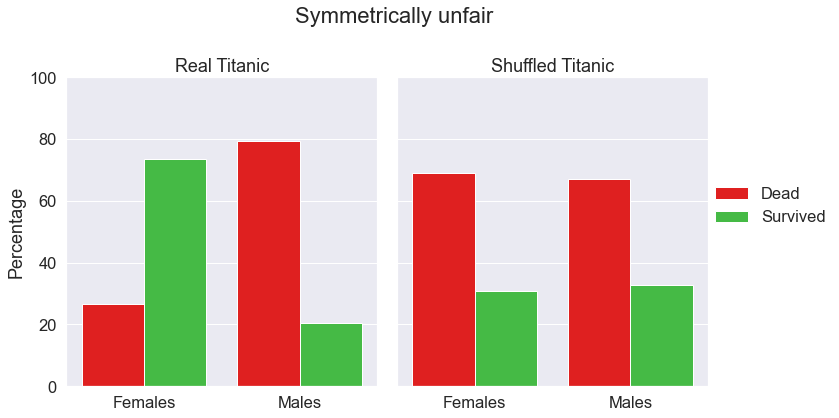

In [14]:
# Calculate percentage of dead and survivors for each sex.
pct_of_survival_by_sex = titanic.groupby("SEX")["SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()
pct_of_survival_by_sex_SHF = titanic.groupby("SEX")["SHF_SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot the above percenages.
fig_survival_by_sex, (ax_survival_by_sex, ax_survival_by_sex_SHF) = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
sns.barplot(x = "SEX", y = "Percentage", hue = "SURVIVED", data = pct_of_survival_by_sex, ax = ax_survival_by_sex, palette = survival_color);
sns.barplot(x = "SEX", y = "Percentage", hue = "SHF_SURVIVED", data = pct_of_survival_by_sex_SHF, ax = ax_survival_by_sex_SHF, palette = survival_color)

# Customise title, axes, and legend.
ax_survival_by_sex.set_ylim(0, 100)
ax_survival_by_sex.set_xlabel("")
ax_survival_by_sex.set_xticklabels(["Females", "Males"])
handles, _ = ax_survival_by_sex.get_legend_handles_labels()
ax_survival_by_sex.legend().set_visible(False);
ax_survival_by_sex.set_title("Real Titanic", fontsize = 18);

ax_survival_by_sex_SHF.set_xlabel("")
ax_survival_by_sex_SHF.set_ylabel("")
ax_survival_by_sex_SHF.set_xticklabels(["Females", "Males"])
ax_survival_by_sex_SHF.legend(loc = (1, 0.5), frameon = False, handles = handles, labels = ["Dead", "Survived"])
ax_survival_by_sex_SHF.set_title("Shuffled Titanic", fontsize = 18)

fig_survival_by_sex.suptitle("Symmetrically unfair", x = 0.47, fontsize = 22)
fig_survival_by_sex.tight_layout();

_`Figure 7. Percentages of victims and survivors among males and females. Real and shuffled Titanic.`_

Let's see whether the percentage of survivors for males and females changes when age is taken into account. Let's create a function to plot the count of a given subset of all people on the _Titanic_ by age bracket, together with the number and percentage of survivors amongst that subset and the number of survivors on the shuffled _Titanic_.

In [148]:
def age_bracket_histogram(ax, affiliation = "Any", sex = "Any"):
    """Plots two histograms on the same axes showing:
     - the subset of people matching `affiliation` and `sex`, and
     - the number and percentage of survivors from the above subset.      
     
     `affiliation` can be `Crew`, `Passengers`, or `Any` (default).
     `sex` can be `Male`, `Female`, or `Any` (default).
     """
    # At first, everyone on board is to be counted.
    matching_people = titanic

    # Match affiliation.
    if affiliation != "Any":        
        matching_people = matching_people.query("AFFILIATION == @affiliation")
    
    # Match sex.
    if sex != "Any":
        matching_people = matching_people.query("SEX == @sex")
    
    matching_people = matching_people.sort_values(by = "AGE_BRACKET")
    survivors = matching_people.query("SURVIVED == True")
    
    # Get the bracket totals.
    totals_by_bracket = matching_people["AGE_BRACKET"].value_counts().sort_index() 
    bracket_index = totals_by_bracket.index # This contains all unique age brackets in the dataset. We'll need it to reindex other counts correctly.
    
    # Get survivor numbers and percentages by age bracket.    
    survivors_by_bracket = survivors["AGE_BRACKET"].value_counts().sort_index()
    # If any bracket doesn't have survivors, the relevant index will be missing from the chart, but we want it (with value 0). Reindex.
    survivors_by_bracket = survivors_by_bracket.reindex(index = bracket_index, fill_value = 0)
    
    pct_survivors_by_bracket = (survivors_by_bracket / totals_by_bracket).mul(100).round()
            
    # Determine survivors on the shuffled Titanic.
    SHF_survivors_by_bracket = matching_people.query("SHF_SURVIVED == True")["AGE_BRACKET"].value_counts().sort_index()
    # Reindex to make up for any empty brackets.
    SHF_survivors_by_bracket = SHF_survivors_by_bracket.reindex(index = bracket_index, fill_value = 0)
       
    # Plot the histograms.
    num_brackets = len(bracket_index)
    bins =  range(num_brackets + 1)
            
    # First, plot matching_people.    
    ax.hist(x = matching_people["AGE_BRACKET"], bins = bins, align = "left", alpha = 0.5, label = "Everyone", color = sex_color[sex])
    
    # Then, plot survivors amongst matching_people. Store the bar heights.
    heights, _, _ = ax.hist(x = survivors["AGE_BRACKET"], bins = bins, align = "left", color = survival_color[True], label = "Survivors")
    
    # Add percent labels on top of survivor bars.
    y_offset = 20 # Desired distance between each bar and its label, in points.        
    for pct, y, x in zip(pct_survivors_by_bracket, heights, bins):
        pct = "{}%".format(round(pct))                    
        txt = ax.annotate(pct, xy = (x, y), xycoords = ("data", "data"), xytext = (0, y_offset), textcoords = "offset points", va = "top", ha = "center",
                          fontsize = "small", color = survival_color[True], fontweight = "bold")       
        txt.set_path_effects([path_effects.Stroke(linewidth = 3, foreground = "black"), path_effects.Normal()])
    
    # Plot the shuffled survivors.    
    ax.plot(SHF_survivors_by_bracket.to_numpy(), marker = "o", linewidth = 2, color = "red", label = "Survivors (SHF)", alpha = 0.6)    
    ax.legend(frameon = False)
    
def rotate_xtick_labels(ax):
    """Rotates `ax`'s xtick labels to improve legibility.
    
    `ax`: matplotlib axes.    
    """
    for tick in ax.get_xticklabels():
        tick.set_rotation(45) 

The histogram below shows all people on the _Titanic_ categorised by age group, together with the survivors and shuffled survivors for each bracket. (Note that the green percentages only refer to the real _Titanic_; the green bars and the red line are absolute counts in this and similar charts.) We see that, with few exceptions, survivors are always below 50% for each bracket; the numbers of shuffled survivors for each age bracket are often close to those actually observed, suggesting that age might not have been a very important factor determining survival.

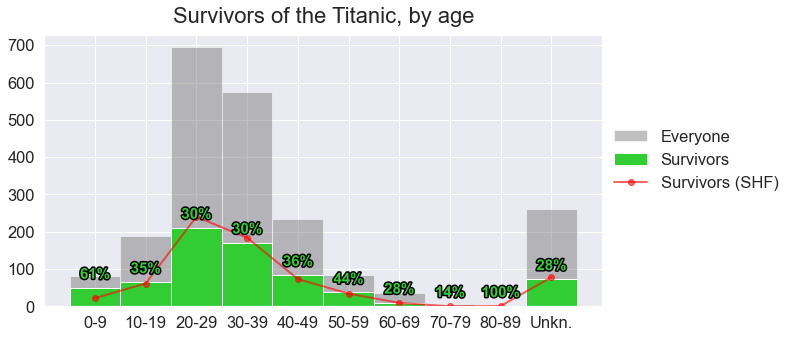

In [134]:
# Plot the age distribution of everyone on board. Highlight survivors in absolute and percentage terms.
fig_everyone_by_age, ax_everyone_by_age = plt.subplots(1, 1, figsize = (10, 5))
surv_by_age = age_bracket_histogram(ax_everyone_by_age)

# Customise title and legend.
ax_everyone_by_age.legend(loc = (1.01, 0.4), frameon = False);
ax_everyone_by_age.set_title("Survivors of the Titanic, by age", fontsize = 22, y = 1.02);

_`Figure 8. Titanic survivors by age bracket. Real and shuffled Titanic.`_

The situation changes quite dramatically when sex is taken into account: **the percentage of female survivors is always significantly above 50%, no matter the age bracket; for males, only two brackets have a percentage of survivors higher than 50%,** while all others are between 0 and 22 percent. While the difference in size of each age bracket between the sexes is significant, the pattern is perfectly consistent; for each shared age bracket, female survival rates are moderately to much higher compared to male survival rates. Additionally, if we compare the real _Titanic_ to the shuffled _Titanic_, we see that on the latter far fewer females survived per age bracket, sometimes significantly so; the opposite is true for males, for nearly every age bracket.

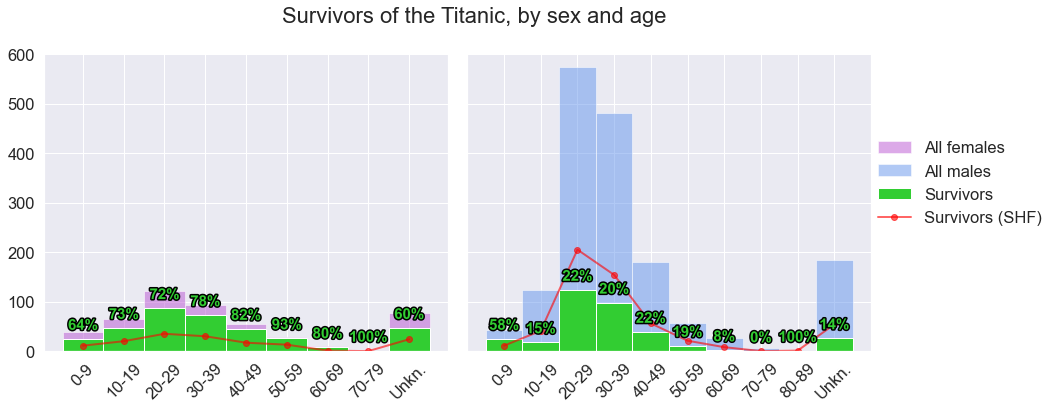

In [154]:
fig_everyone_by_age_and_sex, (ax_females_by_age, ax_males_by_age) = plt.subplots(1, 2, figsize = (15, 6), sharey = True)

# Plot the age distribution of everyone on board by sex. Highlight survivors in absolute and percentage terms.

# Females
age_bracket_histogram(ax_females_by_age, sex = "Female")
f_handles, _ = ax_females_by_age.get_legend_handles_labels()
f_handles = [f_handles[0]] # Take only the first handle. (Otherwise we'd have "Survivors" twice in the legend.)
ax_females_by_age.legend().remove()
rotate_xtick_labels(ax_females_by_age)

# Males
age_bracket_histogram(ax_males_by_age, sex = "Male")
m_handles, _ = ax_males_by_age.get_legend_handles_labels()
handles = f_handles + m_handles
labels = ["All females", "All males", "Survivors", "Survivors (SHF)"]
#ax_males_by_age.legend().remove()
ax_males_by_age.legend(handles = handles, labels = labels, frameon = False, loc = (1, 0.4));
rotate_xtick_labels(ax_males_by_age)

# Customise figure properties.
fig_everyone_by_age_and_sex.suptitle("Survivors of the Titanic, by sex and age", fontsize = 22, x = 0.45, y = 0.96)
fig_everyone_by_age_and_sex.tight_layout()

_`Figure 9. Survivors of both the real and shuffled Titanic, by sex and age bracket.`_

So far, we've looked at all the people on board, regardless of whether they were crew or passengers. This might skew the results significantly if, for whatever reason, crew members were more (or less) likely to survive than passengers; so, let's look at how the picture changes when affiliation is taken into account.

### Crew survival

Let's start by answering the question: **Were crew members more or less likely to survive, compared to passengers?** In percentage, crew members were fewer than passengers both among victims and survivors; in other words, both a random victim and a random survivor are less likely to have been a crew member. Note however that, if being crew or passenger made no difference in terms of survival chances, you'd expect to see the same crew-passenger split among victims and survivors as you do on the whole ship, i.e. about 40-60, while we see that the situation is slightly better for passengers.

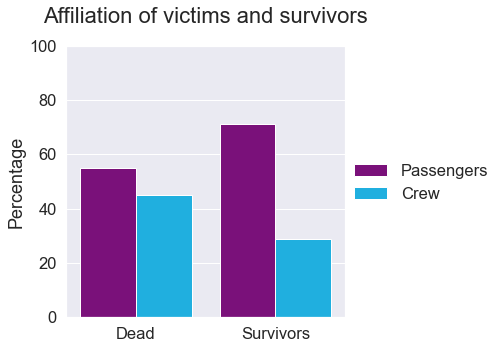

In [132]:
# Calculate the percentages of crew and passengers among dead and survivors.
pct_crew_vs_passengers_by_survival = titanic.groupby("SURVIVED")["AFFILIATION"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot the above percentages.
fig_crew_vs_passengers, ax_crew_vs_passengers = plt.subplots(1, 1, figsize = (5, 5))
sns.barplot(x = "SURVIVED", y = "Percentage", hue = "AFFILIATION", data = pct_crew_vs_passengers_by_survival, ax = ax_crew_vs_passengers, palette = affiliation_color);

# Customise axes, title, and legend.
ax_crew_vs_passengers.set_ylim(0, 100)
ax_crew_vs_passengers.set_xlabel("")
ax_crew_vs_passengers.legend(loc = (1.01, 0.4), frameon = False)
ax_crew_vs_passengers.set_xticklabels(["Dead", "Survivors"]);
ax_crew_vs_passengers.set_title("Affiliation of victims and survivors", fontsize = 22,  y = 1.06);

_`Figure 10. Percentages of passengers and crew among victims and survivors.`_

Indeed, **a random crew member has almost an 80% chance of being a victim, against about 60% for a random passenger.** Since most crew members were men, this suggests that at least some of the imbalance seen in the survival rates of men and women may not depend on the unwritten rule "women and children first", but rather on a possible "passengers first" rule. It's likely that many crew members, such as officers or deck staff, were left behind as they supervised the evacuation of the ship. Others still, like engineers, were deep in the belly of the ship, and escaping was harder for them. (Not to mention that they tried to keep the electrical systems going almost until the very end.)

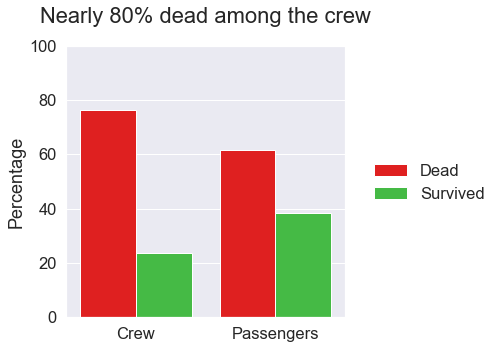

In [133]:
# Calculate perentage of dead and survivors among crew and passengers.
pct_of_survival_by_affiliation = titanic.groupby("AFFILIATION")["SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot the above percentages.
fig_survival_by_affiliation, ax_survival_by_affiliation = plt.subplots(1, 1, figsize = (5, 5))
sns.barplot(x = "AFFILIATION", y = "Percentage", hue = "SURVIVED", data = pct_of_survival_by_affiliation, palette = survival_color);

# Customise title, axes, and legend.
ax_survival_by_affiliation.set_ylim(0, 100)
ax_survival_by_affiliation.set_xlabel("")
ax_survival_by_affiliation.legend(loc = (1.01, 0.4), frameon = False)
handles, _ = ax_survival_by_affiliation.get_legend_handles_labels()
ax_survival_by_affiliation.legend(loc = (1.08, 0.4), frameon = False, handles = handles, labels = ["Dead", "Survived"]);
ax_survival_by_affiliation.set_title("Nearly 80% dead among the crew", fontsize = 22, y = 1.06);

_`Figure 11. Survival and death rate among crew and passengers.`_

Since women were a negligible part of the crew, seeing what pecentage of survivors and victims amongst the crew were women wouldn't be very informative; it was perforce a very small percentage in both cases. It's going to be more interesting to see what percentage of men and women of the crew survived or died.

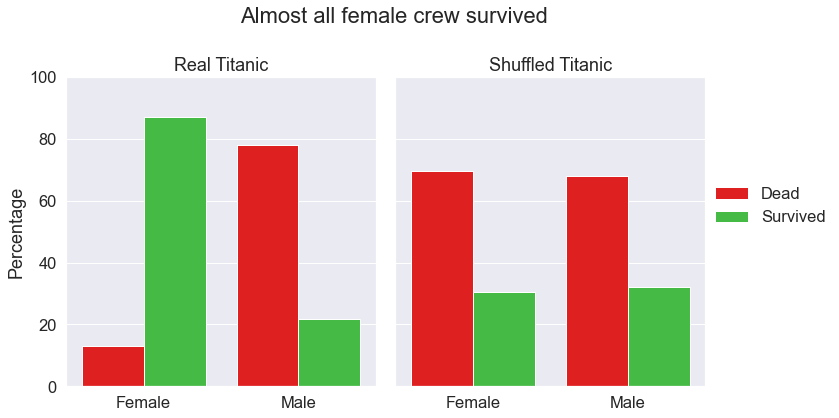

In [134]:
# Calculate percentage of dead and survivors among crew memebers of both sexes.
crew_pct_of_survival_by_sex = crew.groupby("SEX")["SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()
crew_pct_of_survival_by_sex_SHF = crew.groupby("SEX")["SHF_SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot the above percentages.
fig_crew_survival_by_sex, (ax_crew_survival_by_sex, ax_crew_survival_by_sex_SHF) = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
sns.barplot(x = "SEX", y = "Percentage", hue = "SURVIVED", data = crew_pct_of_survival_by_sex, ax = ax_crew_survival_by_sex, palette = survival_color)
sns.barplot(x = "SEX", y = "Percentage", hue = "SHF_SURVIVED", data = crew_pct_of_survival_by_sex_SHF, ax = ax_crew_survival_by_sex_SHF, palette = survival_color)

# Customise title, axes, and legend.
ax_crew_survival_by_sex.set_ylim(0, 100)
ax_crew_survival_by_sex.set_xlabel("")
ax_crew_survival_by_sex.legend().set_visible(False)
ax_crew_survival_by_sex.set_title("Real Titanic")

ax_crew_survival_by_sex_SHF.set_xlabel("")
ax_crew_survival_by_sex_SHF.set_ylabel("")
ax_crew_survival_by_sex_SHF.set_title("Shuffled Titanic")
handles, _ = ax_crew_survival_by_sex_SHF.get_legend_handles_labels()
ax_crew_survival_by_sex_SHF.legend(loc = (1.01, 0.5), frameon = False, handles = handles, labels = ["Dead", "Survived"]);

fig_crew_survival_by_sex.suptitle("Almost all female crew survived", fontsize = 22, x = 0.47)
fig_crew_survival_by_sex.tight_layout();

_`Figure 12. Crew survival and death rates on both the real and shuffled Titanic, by sex.`_

From the charts above, we can see that the survival chances of male and female crew members is comparable to that of people on the ship as a whole—or at least, it is for males. 

- **Male crew members have a death rate of about 78%;** across the whole ship, the same rate for males is 79%.
- **Female crew members have a death rate of 13%;** across the whole ship, the same rate for females is about 26.5%.

Put in another way, **a randomly chosen male on the _Titanic_ has a very high chance to be a victim to begin with; if we know that he was crew, this changes virtually nothing.** This isn't true for females, who are half as likely to be amongst victims if they're crew, although both likelihoods are much lower than they are for males. Since only 23 women in total were part of the crew, it's not impossible that their high survival rate might have been due to mere chance; however, on the shuffled _Titanic_, where _everything_ was up to mere chance, we see that both males and females died and survived in very similar percentages.

As we've seen in `Figure 3`, female crew were only part of the Restaurant or Victualling crew. Twenty-one of them were in Victualling, while the remaining two women were in the Restaurant crew. Since nearly all female crew survived, we automatically know that nearly all the female Victualling crew survived too, despite the fact that, as we can see below, Victualling was one of the groups with the highest death rates. (As a side note, both women in the Restaurant group survived.)

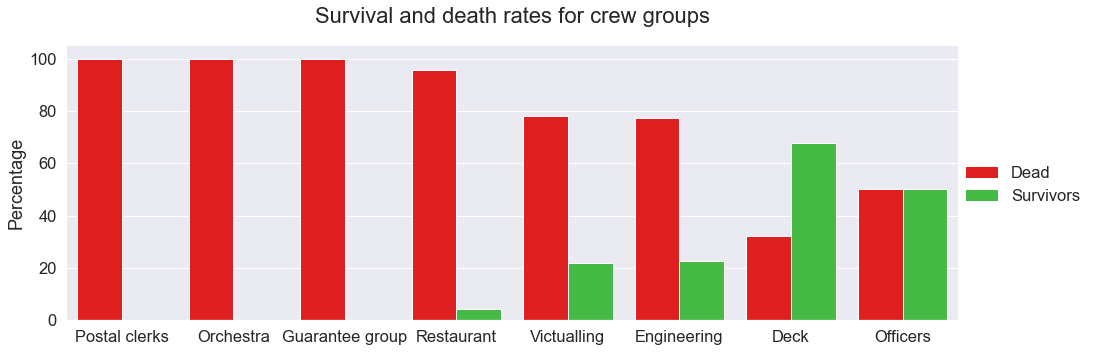

In [135]:
# Calculate percentages of dead and survivors among every crew group.
pct_survival_by_group = (crew.groupby("GROUP")["SURVIVED"]
                         .value_counts(normalize = True).mul(100)
                         .rename("Percentage").reset_index().sort_values(by = ["Percentage", "GROUP"], ascending = False))

# Plot the above percentages.
grid_survival_by_group = sns.catplot(x = "GROUP", y = "Percentage", hue = "SURVIVED", kind = "bar", data = pct_survival_by_group, 
                                     aspect = 22/8, palette = survival_color, legend = False)

# Customise title, axes, and legend.
ax_survival_by_group = grid_survival_by_group.axes[0][0]
ax_survival_by_group.set_xlabel("")
handles, _ = ax_survival_by_group.get_legend_handles_labels()
ax_survival_by_group.legend(loc = (1, 0.4), frameon = False, handles = handles, labels = ["Dead", "Survivors"])
ax_survival_by_group.set_title("Survival and death rates for crew groups", fontsize = 22, y = 1.06);

_`Figure 13. Survival and death rates of the crew on the real Titanic, by crew group.`_

With a group size of merely 21 individuals, random chance *might* have caused the high survival rate of Victualling women, but it's hard not to notice that all female groups we've seen so far have had very high survival rates, regardless of size; instead, Postal clerks, the Orchestra, and the Guarantee group—small all-male groups with less than 10 people each—all had a 100% death rate. 

Below is the number of survivors among crew members, illustrated by age bracket.

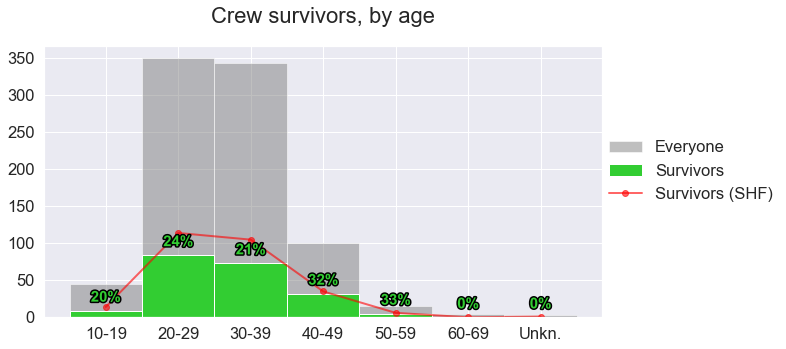

In [156]:
# Plot the crew's age distribution. Highlight survivors in each age bracket, both in absolute and percentage terms.
fig_crew_by_age, ax_crew_by_age = plt.subplots(1, 1, figsize = (10, 5))
age_bracket_histogram(ax = ax_crew_by_age, affiliation = "Crew")
ax_crew_by_age.set_title("Crew survivors, by age", fontsize = 22, y = 1.06)
ax_crew_by_age.legend(loc = (1, 0.4), frameon = False);

_`Figure 14. Survival of the crew by age bracket. Real and shuffled Titanic.`_

As we can see below, **female crew survived in much higher percentages than male crew in every bracket.** While female age brackets have far fewer people than male age brackets, the situation on the shuffled _Titanic_ is nonetheless very different. There's a noticeable reduction in female survivors, and small-to-modest increases in the number of male survivors per bracket.

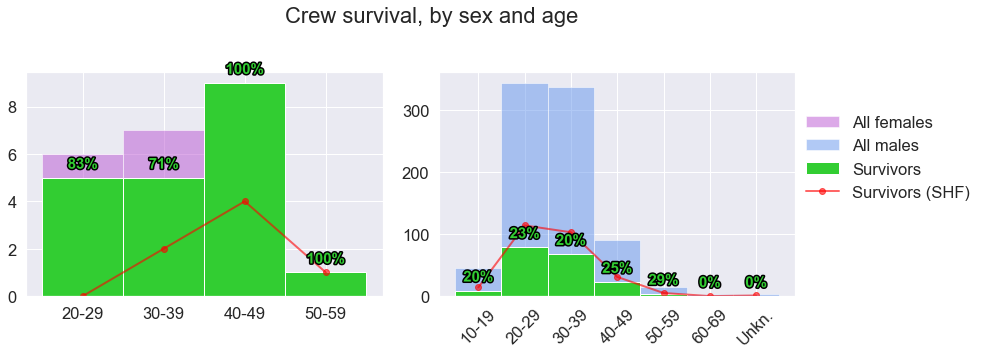

In [158]:
# Plot the crew's age distribution separately for each sex. Highlight survivors in each age bracket, both in absolute and percentage terms.
fig_crew_by_age_and_sex, (ax_female_crew_by_age, ax_male_crew_by_age) = plt.subplots(1, 2, figsize = (14, 5))
age_bracket_histogram(ax_female_crew_by_age, affiliation = "Crew", sex = "Female")
age_bracket_histogram(ax_male_crew_by_age, affiliation = "Crew", sex = "Male")

# Customise legends.
f_handles, _ = ax_female_crew_by_age.get_legend_handles_labels()
f_handles = [f_handles[0]] # Take only the first handle.
m_handles, _ = ax_male_crew_by_age.get_legend_handles_labels()
handles = f_handles + m_handles
labels = ["All females", "All males", "Survivors", "Survivors (SHF)"]
ax_female_crew_by_age.legend().remove()
ax_male_crew_by_age.legend(handles = handles, labels = labels, frameon = False, loc = (1.01, 0.4))
rotate_xtick_labels(ax_male_crew_by_age)

# Customise figure.
fig_crew_by_age_and_sex.suptitle("Crew survival, by sex and age", fontsize = 22, x = 0.44, y = 1)
fig_crew_by_age_and_sex.tight_layout()

_`Figure 15. Crew survival and death rates by sex and age bracket. Real and shuffled Titanic. (Note that the y-axis is different for each chart.)`_

Before moving on to analysing the passengers' survival rates, it would be interesting to take a small detour to see which jobs among the crew were the most dangerous—that is, those with the highest death rates. To make sure the results are meaningful, we'll only consider positions occupied by at least 10 crew members.

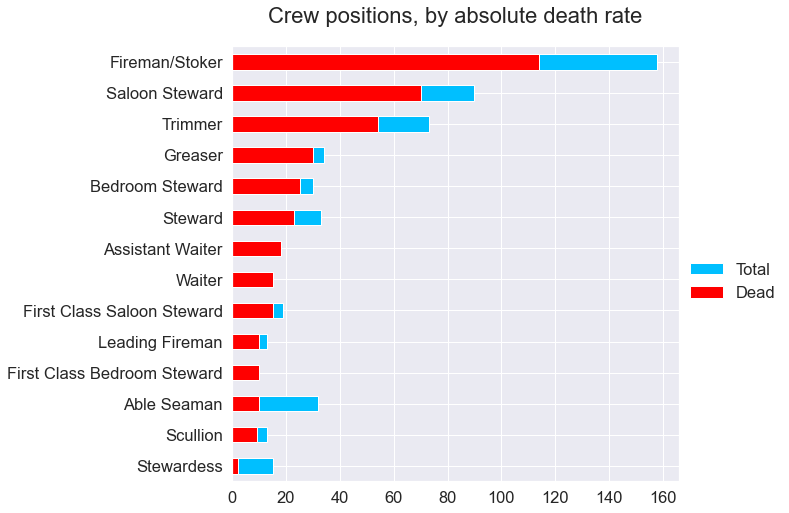

In [138]:
# Find out which positions were occupied by least 10 crew members.
positions_10plus = crew["POSITION"].value_counts()
positions_10plus = positions_10plus[positions_10plus >= 10].index # The index of this series contains all the positions we're interested in.

# Create a dataframe containing the total crew members for each position, and how many died.
survival_by_position = titanic.loc[titanic["POSITION"].isin(positions_10plus),["POSITION", "SURVIVED"]]
survival_by_position = survival_by_position.groupby("POSITION")["SURVIVED"].value_counts().rename("Count").reset_index()
survival_by_position = survival_by_position.pivot(index = "POSITION", columns = "SURVIVED", values = "Count")
survival_by_position = survival_by_position.rename(columns = {False: "DEAD", True: "SURVIVORS"})
survival_by_position.fillna(0, inplace = True)
survival_by_position["TOTAL"] = survival_by_position[["DEAD", "SURVIVORS"]].sum(axis = 1)
survival_by_position.drop(columns = "SURVIVORS", inplace = True) # We don't need the count of survivors, only of the dead.
survival_by_position.sort_values(by = "DEAD", inplace = True)

# Plot the count of total and dead crew members for each position of interest.
fig_survival_by_position, ax_survival_by_position = plt.subplots(1, 1, figsize = (8, 8))
survival_by_position["TOTAL"].plot.barh(ax = ax_survival_by_position, color = affiliation_color["Crew"], label = "Total")
survival_by_position["DEAD"].plot.barh(ax = ax_survival_by_position, color = survival_color[False], label = "Dead");

# Customise axis.
ax_survival_by_position.set_ylabel("")
ax_survival_by_position.set_title("Crew positions, by absolute death rate", fontsize = 22, y = 1.04)
ax_survival_by_position.legend(loc = (1.01, 0.4), frameon = False);

_`Figure 16. Jobs on the Titanic by absolute death rate. Only jobs with at least 10 people considered. Totals shown for comparison.`_

The chart above shows the absolute death rate instead of percentages, because given the significant difference between the sizes of the groups, percentages could be misleading. For example, 100% of waiters on the _Titanic_ died, but there were less than 20 of them in total and it surely wasn't a more dangerous job than that of engineers. With such a small number of waiters, random chance may well have been the most important factor that determined the fate of these unlucky people. By contrast, "only" about 72% of the Firemen/Stokers died, but as they were much more numerous, it's reasonable to conclude that so many of them died not because of chance, but because of their job's inherent risk in the event of the ship sinking. Indeed, they were part of the engineering team, who due to their physical location on the ship, as well as their desperate attempts to keep the systems of the ship going for as long as possible, had it arguably worse than anybody else onboard. (Incidentally, note that "Stewardess"—a job obviously done only by women—is at the bottom of the list, both in absolute and relative terms.)

### Passenger survival

The charts below show the death and survival rates for male and female passengers aboard the real and the shuffled _Titanic_, and it tells the same story as the charts illustrating sex-dependent survival rates for crew memebers and for the whole ship: males were vastly more likely to die than females. Once again, the situation on the shuffled _Titanic_ is far more balanced.

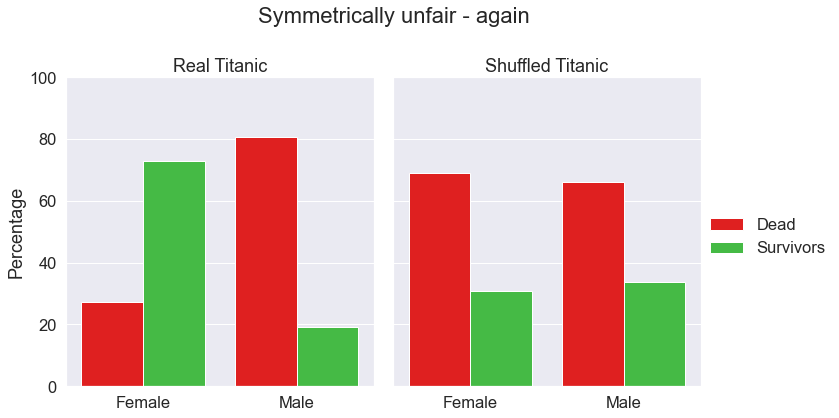

In [139]:
# Calculate the percentage of dead and survivors among passengers of both sexes.
passenger_survival_by_sex = passengers.groupby("SEX")["SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()
passenger_survival_by_sex_SHF = passengers.groupby("SEX")["SHF_SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot the above percentages.
fig_passenger_survival_by_sex, (ax_passenger_survival_by_sex, ax_passenger_survival_by_sex_SHF) = plt.subplots(1, 2, figsize = (12, 6), sharey = True)
sns.barplot(x = "SEX", y = "Percentage", hue = "SURVIVED", data = passenger_survival_by_sex, ax = ax_passenger_survival_by_sex, palette = survival_color);
sns.barplot(x = "SEX", y = "Percentage", hue = "SHF_SURVIVED", data = passenger_survival_by_sex_SHF , ax = ax_passenger_survival_by_sex_SHF, palette = survival_color)

# Customise title, axes, and legend.
ax_passenger_survival_by_sex.set_ylim(0, 100)
ax_passenger_survival_by_sex.set_xlabel("")
ax_passenger_survival_by_sex.legend().remove()
ax_passenger_survival_by_sex.set_title("Real Titanic", fontsize = 18)

ax_passenger_survival_by_sex_SHF.set_xlabel("")
ax_passenger_survival_by_sex_SHF.set_ylabel("")
handles, _ = ax_passenger_survival_by_sex_SHF.get_legend_handles_labels()
ax_passenger_survival_by_sex_SHF.legend(loc = (1.01, 0.4), frameon = False, handles = handles, labels = ["Dead", "Survivors"])
ax_passenger_survival_by_sex_SHF.set_title("Shuffled Titanic", fontsize = 18)

fig_passenger_survival_by_sex.suptitle("Symmetrically unfair - again", fontsize = 22, x = 0.47)
fig_passenger_survival_by_sex.tight_layout();

_`Figure 17. Passenger survival and death rates by sex. Real and shuffled Titanic.`_

It's worth asking whether passengers of different classes had different survival rates, and the answer is a predictable "yes".

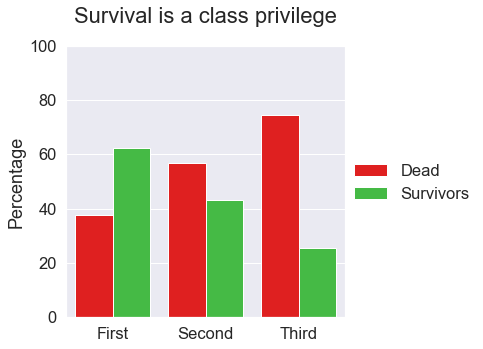

In [140]:
# Calculate survival and death percentages for passengers of each class.
survival_by_class = titanic.query("AFFILIATION == 'Passengers'").groupby("CLASS")["SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot the above percentages.
fig_survival_by_class, ax_survival_by_class = plt.subplots(1, 1, figsize = (5, 5))
sns.barplot(x = "CLASS", y = "Percentage", hue = "SURVIVED", data = survival_by_class, ax = ax_survival_by_class, palette = survival_color);

# Customise title, axes, and legend.
ax_survival_by_class.set_ylim(0, 100)
ax_survival_by_class.set_xlabel("")
handles, _ = ax_survival_by_class.get_legend_handles_labels()
ax_survival_by_class.legend(loc = (1.01, 0.4), frameon = False, handles = handles, labels = ["Dead", "Survivors"])
ax_survival_by_class.set_title("Survival is a class privilege", fontsize = 22, y = 1.06);

_`Figure 18. Passenger survival and death rates, by class.`_

The chart leaves no doubt that class and death rates on the _Titanic_ were correlated: the lower the class, the higher the death rate, and obviously vice-versa for the survival rate. The reasons for this may be many, for example the location of cabins of different classes, possible discrimination operated by the crew, or the strings that higher-class passengers might have been able to pull to more easily secure a place on a lifeboat. However, once more this trend changes significantly when sex is accounted for.

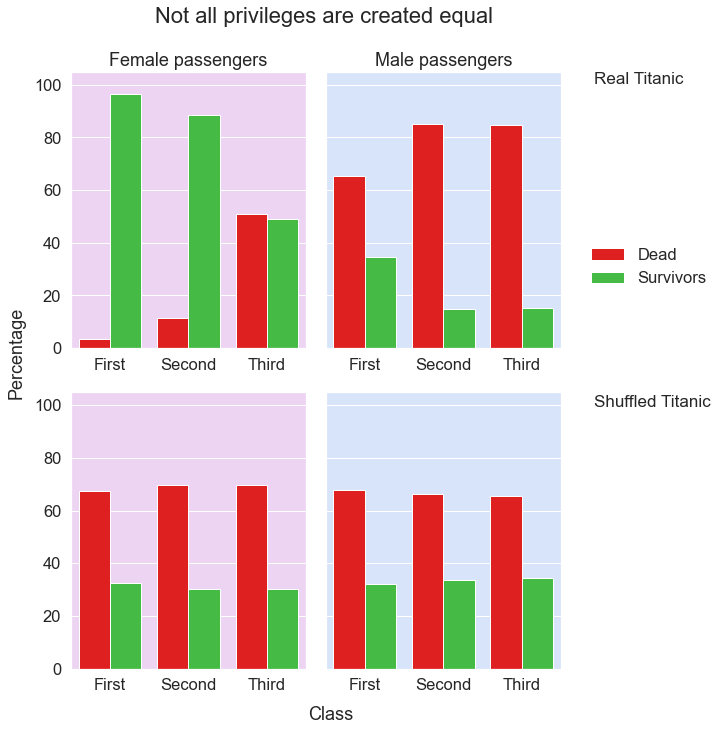

In [141]:
# Calculate percentages of dead and survivors separately for both sexes, by class.

#Real Titanic
fem_survival_by_class = passengers.query("SEX == 'Female'").groupby("CLASS")["SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()
male_survival_by_class = passengers.query("SEX == 'Male'").groupby("CLASS")["SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Shuffled Titanic
fem_survival_by_class_SHF = passengers.query("SEX == 'Female'").groupby("CLASS")["SHF_SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()
male_survival_by_class_SHF = passengers.query("SEX == 'Male'").groupby("CLASS")["SHF_SURVIVED"].value_counts(normalize = True).mul(100).rename("Percentage").reset_index()

# Plot the above percentages.
fig_sex_and_class, ((ax_fem_class, ax_male_class), (ax_fem_class_SHF, ax_male_class_SHF)) = plt.subplots(2, 2, figsize = (10, 10), sharey = True)

# Real Titanic
sns.barplot(x = "CLASS", y = "Percentage", hue = "SURVIVED", data = fem_survival_by_class, ax = ax_fem_class, palette = survival_color)
sns.barplot(x = "CLASS", y = "Percentage", hue = "SURVIVED", data = male_survival_by_class, ax = ax_male_class, palette = survival_color)

# Shuffled Titanic
sns.barplot(x = "CLASS", y = "Percentage", hue = "SHF_SURVIVED", data = fem_survival_by_class_SHF, ax = ax_fem_class_SHF, palette = survival_color)
sns.barplot(x = "CLASS", y = "Percentage", hue = "SHF_SURVIVED", data = male_survival_by_class_SHF, ax = ax_male_class_SHF, palette = survival_color)

# Customise titles, axes, and legends.
ax_fem_class.set_title("Female passengers")
ax_fem_class.set_ylim(0, 105)
ax_fem_class.legend().remove()
ax_fem_class.set_facecolor(sex_color["Female"])
ax_fem_class.patch.set_alpha(0.25)
ax_fem_class.set_xlabel("")
ax_fem_class.set_ylabel("")

ax_male_class.set_title("Male passengers")
ax_male_class.set_xlabel("")
ax_male_class.set_ylabel("")
ax_male_class.set_facecolor(sex_color["Male"])
handles, _ = ax_male_class.get_legend_handles_labels()
ax_male_class.patch.set_alpha(0.25)
ax_male_class.legend(loc = (1.1, 0.2), handles = handles, labels = ["Dead", "Survivors"], frameon = False)

ax_fem_class_SHF.legend().remove()
ax_fem_class_SHF.set_facecolor(sex_color["Female"])
ax_fem_class_SHF.patch.set_alpha(0.25)
ax_fem_class_SHF.set_xlabel("")
ax_fem_class_SHF.set_ylabel("")

ax_male_class_SHF.set_xlabel("")
ax_male_class_SHF.set_ylabel("")
ax_male_class_SHF.set_facecolor(sex_color["Male"])
ax_male_class_SHF.patch.set_alpha(0.25)
ax_male_class_SHF.legend().remove()

# Customise figure.
fig_sex_and_class.suptitle("Not all privileges are created equal", fontsize = 22, x = 0.43);
fig_sex_and_class.text(0.805, 0.873, "Real Titanic", fontsize = 17)
fig_sex_and_class.text(0.805, 0.425, "Shuffled Titanic", fontsize = 17)
fig_sex_and_class.text(-0.01, 0.5, "Percentage", va = "center", rotation = "vertical")
fig_sex_and_class.text(0.44, -0.01, "Class", ha = "center")
fig_sex_and_class.tight_layout();

_`Figure 19. Survival and death rates by sex and class. Real (top) and shuffled (bottom) Titanic.`_

The pattern "high class, low death" is not only preserved, but it is even more evident when looking at female passengers only: **death rates for female passengers decrease almost four-fold with each step from lower to higher class.** However, death rates among males are virtually identical (slightly above 80%) for second and third class passengers; first-class male passengers had it only slightly better, with a death rate of about 65%. A randomly chosen third-class female passenger of the _Titanic_ has a pretty much fair chance of being a survivor, about 15% higher than for a randomly chosen first-class male passenger. **A higher-class ticket always came with significantly better survival chances for female passengers; not so for males.** On the shuffled _Titanic_, class privilege is just not a thing; female and male passengers survive and die in very similar percentages across all classes.

Age is another factor that could impact survival: older passengers might have had a harder time fleeing or finding their way to the lifeboats, and the same is true for very young children, who most likely could not escape without the assistance of an adult. We can check that by plotting passenger survival rates by age bracket.

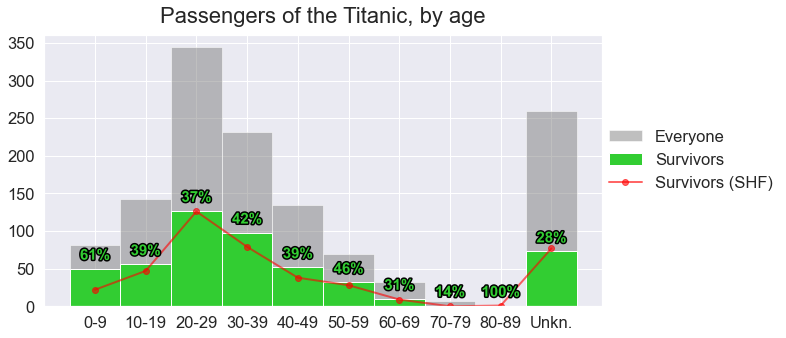

In [161]:
# Calculate and plot the passengers' age distribution. Highlight survivors both in absolute and percentage terms.
fig_passengers_by_age, ax_passengers_by_age = plt.subplots(1, 1, figsize = (10, 5))
age_bracket_histogram(ax = ax_passengers_by_age, affiliation = "Passengers")
ax_passengers_by_age.set_title("Passengers of the Titanic, by age", fontsize = 22, y = 1.02)
ax_passengers_by_age.legend(loc = (1, 0.4), frameon = False);

_`Figure 20. Passenger and survived passenger count on the Titanic, by age bracket. The red line shows the survivor count on the shuffled Titanic.`_

Survival rates are actually higher amongst the youngest and oldest, though their small number, especially for the latter cohort, is likely an important factor. It's not so strange, however that the youngest cohort had such a high survival rate, as their parents must surely have tried their hardest to ensure they wouldn't die. Survival rates are anyway fairly low amongst people between 60 and 79, for reasons that may include self-sacrifice or higher difficulty in escaping, but on which we can ultimately only speculate. Note, however, that just like in `Figure 8` we saw that the real survival rates by bracket were very close to shuffled ones for the whole ship, they're fairly close to each other for passengers only as well, again suggesting that the role of age might have been limited.

Once again, **splitting the above histogram by sex reveals very different trends among males and females;** among male passengers, only children aged 0-9 and men aged 80-89 had exceptionally high survival rates; among female passengers, survival rates were always very high, 64% at a minimum. While these two distributions have a different number of age brackets of rather different sizes compared to the same distributions for the crew, the situation is again very similar: very low survival rates for (most) males, very high survival rates for all females. The situation is much more balanced on the shuffled _Titanic_ —which, let's not forget, has nonetheless the same overall death rate as the real _Titanic_.

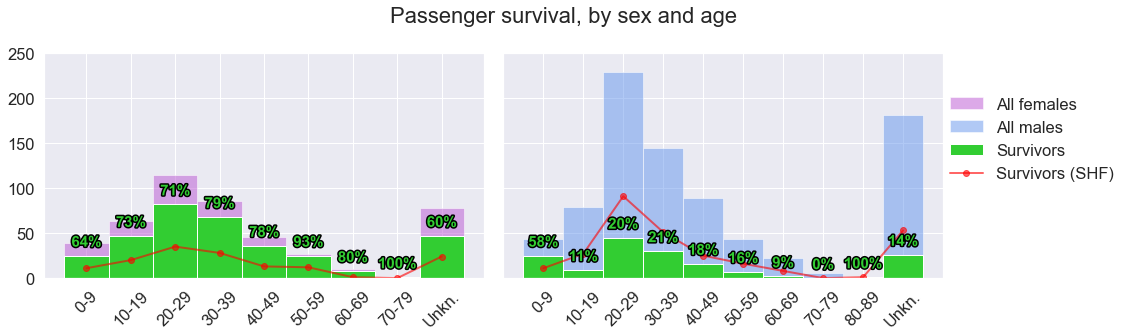

In [163]:
# Calculate and plot the passengers' age distribution separately for each sex. Highlight survivors both in absolute and percentage terms.
fig_passengers_by_age_and_sex, (ax_female_passengers_by_age, ax_male_passengers_by_age) = plt.subplots(1, 2, figsize = (16, 5), sharey = True)
age_bracket_histogram(ax_female_passengers_by_age, affiliation = "Passengers", sex = "Female")
age_bracket_histogram(ax_male_passengers_by_age, affiliation = "Passengers", sex = "Male")

# Customise axes, legends, and figure.
ax_female_passengers_by_age.set_ylim(0, 250)
f_handles, _ = ax_female_passengers_by_age.get_legend_handles_labels()
f_handles = [f_handles[0]] # Take only the first handle.
ax_female_passengers_by_age.legend().remove()
rotate_xtick_labels(ax_female_passengers_by_age)
rotate_xtick_labels(ax_male_passengers_by_age)

m_handles, _ = ax_male_passengers_by_age.get_legend_handles_labels()
handles = f_handles + m_handles
ax_male_passengers_by_age.legend(handles = handles, labels = ["All females", "All males", "Survivors", "Survivors (SHF)"], frameon = False, loc = (1, 0.4))

fig_passengers_by_age_and_sex.suptitle("Passenger survival, by sex and age", fontsize = 22, y = 0.95)
fig_passengers_by_age_and_sex.tight_layout()

_`Figure 21. Passenger count and survived passenger count by sex and age bracket. The red line shows the survivor count on the shuffled Titanic.`_

What we've seen so far highlights quite clearly the different survival rates for men and women, but it's not very clear at this point if more children or more adults lost their lives on the _Titanic_. A glance at the charts above is enough to tell that more adults died in absolute terms, but let's try to quantify this more precisely. Let's define "adult" as anyone aged at least 18 and "child" anyone younger than 18, and let's crunch the numbers.

In [144]:
# Identify adults and children.
adults = titanic.query("AGE >= 18")
children = titanic.query("AGE < 18")

def calculate_percentage(row, survivors):
    """Calculate percentages of dead or survivors in `row`.
    
    `row` is a dataframe row containing absolute numbers of dead and survivors in a given category (e.g., adult males).
    `survivors` is a boolean specifying whether the percentage of survivors or dead should be computed.
    """
    total = row["SURVIVOR_COUNT"] + row["DEAD_COUNT"]
    
    value = row["SURVIVOR_COUNT"]    
    if survivors == False: value = row["DEAD_COUNT"]    
    
    pct = round((value / total) * 100, 2)    
    return pct
    
age_groups_survival = pd.DataFrame()

# Adults
age_groups_survival.at["Female adults", "SURVIVOR_COUNT"] = len(adults.query("SEX == 'Female' and SURVIVED == True"))
age_groups_survival.at["Female adults", "DEAD_COUNT"] = len(adults.query("SEX == 'Female' and SURVIVED == False"))
age_groups_survival.at["Male adults", "SURVIVOR_COUNT"] = len(adults.query("SEX == 'Male' and SURVIVED == True"))
age_groups_survival.at["Male adults", "DEAD_COUNT"] = len(adults.query("SEX == 'Male' and SURVIVED == False"))

# Children
age_groups_survival.at["Female children", "SURVIVOR_COUNT"] = len(children.query("SEX == 'Female' and SURVIVED == True"))
age_groups_survival.at["Female children", "DEAD_COUNT"] = len(children.query("SEX == 'Female' and SURVIVED == False"))
age_groups_survival.at["Male children", "SURVIVOR_COUNT"] = len(children.query("SEX == 'Male' and SURVIVED == True"))
age_groups_survival.at["Male children", "DEAD_COUNT"] = len(children.query("SEX == 'Male' and SURVIVED == False"))

# Percentages
age_groups_survival["SURVIVOR_PCT"] = age_groups_survival.apply(calculate_percentage, args = (True,), axis = 1)
age_groups_survival["DEAD_PCT"] = age_groups_survival.apply(calculate_percentage, args = (False,), axis = 1)

# Compute category totals from the survivor and dead counts, then drop them.
age_groups_survival["TOTAL"] = age_groups_survival[["SURVIVOR_COUNT", "DEAD_COUNT"]].apply(lambda row: row[0] + row[1], axis = 1)
age_groups_survival["TOTAL"] = age_groups_survival["TOTAL"].astype(int)
age_groups_survival.drop(columns = ["SURVIVOR_COUNT", "DEAD_COUNT"], inplace = True)

The table below shows the four categories sorted by their percentage of survivors. **Female adults have the highest percentage,** followed by female children and male children. Male adults come in last, with less than 21% of survivors. The `TOTAL` column shows the total count of people that were in each category.

In [145]:
age_groups_survival[["SURVIVOR_PCT", "DEAD_PCT", "TOTAL"]].sort_values(by = "SURVIVOR_PCT", ascending = False)

,SURVIVOR_PCT,DEAD_PCT,TOTAL
Female adults,77.29,22.71,339
Female children,69.44,30.56,72
Male children,32.65,67.35,98
Male adults,20.52,79.48,1394


_`Table 1. Total count and percentage of survivors\dead among adults and children of both sexes.`_

## Conclusions

We've analysed the survival rates for different groups of people aboard the _Titanic_, and compared some of them to those observed on the "shuffled _Titanic_"—that is, an imaginary ship that had the exact same overall death and survival rates, but whose victims and survivors were chosen entirely randomly.

The analysis leaves little doubt that **women and children did indeed come first:** no matter how you look at it, women had much lower death rates than males, irrespective of affiliation, age, or class. The number of women on the _Titanic_ was very small compared to that of men, and thus it might be that at least in the case of some particularly small subset of women, random chance might have determined their high survival rates. This, however, happened systematically for each and every group of women considered, while it hardly ever happened for any group of men, no matter how small. Additionally, on the shuffled _Titanic_, women and men died in very similar percentages, and no bias in favour of female (or male) survival was observed, irrespective of group size. (It should be noted that, on the shuffled _Titanic_, any possible influencing factor was eliminated, not just sex.) We also saw that, on the real _Titanic_, female adults had the highest survival rates, followed by female children, male children, and finally adult males.

Given the above, it's very unlikely that the imbalance in survival rates observed on the _Titanic_ was due to mere chance; "women and children first" was definitely at play, whether intentionally or by unconscious bias. Naturally, it is also possible that some other factor might have been at play—women might have a stronger survival instinct, for example, or be more resilient to the conditions everyone was exposed to during the tragedy—but this is mere speculation and not something we can infer from the data.